Import packages

In [323]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statistics
from statistics import mean
from datetime import datetime
from operator import add
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.impute import KNNImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, BaggingRegressor
from sklearn.tree import ExtraTreeRegressor, DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor

Import datasets

In [265]:
data = pd.read_csv('ucf_PSCU_UCF_2021_Data.csv')  
score = pd.read_csv('20211104_APPEND_ucf_bureau_score_history.csv')
rate = pd.read_csv('20211104_APPEND_ucf_rates_history.csv')
debt = pd.read_csv('ucf_unsecured_debt.csv') 

Since target variable 'credit_line_amount', delete the missing values over this column. The number of observations of target variable is 31418, which is 0:31417 in Python

In [274]:
data1 = data.dropna(axis='index', how='all', subset=['credit_line_amount'])  

Check empty columns in ucf_PSCU_UCF_2021_Data.csv

In [88]:
data1.isnull().sum()

Unnamed: 0                                          0
ucfID                                               0
lifetime_delinquent_cycle_count                     0
lifetime_delinquent_1_cycle_count                   0
lifetime_delinquent_2_cycles_count                  0
card_open_date                                      0
credit_line_last_change_date                        6
card_expiration_date                                0
credit_bureau_score                                 0
credit_bureau_score_date                           56
primary_cardholder_debt_to_income_ratio         31417
year_to_date_high_balance_amount                    0
previous_year_high_balance_amount                   0
lifetime_high_balance_amount                        0
last_purchase_date                               1448
last_cash_advance_date                          18368
last_transaction_date                             843
card_account_transfer_upgrade_date              27264
predictive_hardship_score   

Delete empty columns and the variable 'card_account_transfer_upgrade_date' has 86% of missing values

In [276]:
data2 = data1.drop(columns =['card_account_transfer_upgrade_date','primary_cardholder_debt_to_income_ratio',\
                             'predictive_hardship_score', 'predictive_hardship_score_date','predictive_attrition_score',\
                             'predictive_attrition_score_date','predictive_growth_score', 'predictive_growth_score_date',\
                             'primary_cardholder_personal_monthly_income','primary_cardholder_disposable_monthly_income'])

Remove missing values from 'credit_line_last_change_date'

In [277]:
data3 = data2[data2['credit_line_last_change_date'].notna()]

Convert string to datetime for date variables in ucf_PSCU_UCF_2021_Data.csv (data3), 20211104_APPEND_ucf_rates_history.csv (rate) and 20211104_APPEND_ucf_bureau_score_history.csv (score)

In [280]:
lastchangedate = list(data3['credit_line_last_change_date'])
lastchangedate = [datetime.strptime(str(lastchangedate[i]), '%Y/%m/%d %H:%M:%S').date() for i in range(len(lastchangedate))]
score.iloc[:,-1] = [datetime.strptime(str(x), '%Y-%m-%d').date() for x in score.iloc[:,-1]]
rate.iloc[:,-1] = [datetime.strptime(str(x), '%Y-%m-%d').date() for x in rate.iloc[:,-1]]

Comparing with the 'credit_line_last_change_date' in ucf_PSCU_UCF_2021_Data.csv (data3) and given the same 'ucfID' in both csv, find nearest date and before (if possible) on 'credit_bureau_score_date' of score data

In [281]:
N = len(data3)
score_rowindex = np.zeros(N)
for i in range(N):
    lastchanged = lastchangedate[i]
    ucfid = data3.iloc[i,1]
    rows = score.index[score['ucfID'] == ucfid].tolist() 
    if len(rows) == 0:
        score_rowindex[i] = -1
    else:
        tem = [0 for n in range(len(rows))]
        for j,c in enumerate(rows):
            diff = lastchanged - score.iloc[c,-1]
            tem[j] = diff.days # Convert date to day
        if all(n < 0 for n in tem):
            score_rowindex[i] = rows[tem.index(max(tem))]
        else:
            score_rowindex[i] = rows[tem.index(min([n for n in tem if n >= 0]))]

Comparing with the 'credit_line_last_change_date' in ucf_PSCU_UCF_2021_Data.csv (data3) and given the same 'ucfID' in both csv, find nearest date and before (if possible) on 'ProcessDate' of rate data

In [282]:
rate_rowindex = np.zeros(N)
for i in range(N):
    lastchanged = lastchangedate[i]
    ucfid = data3.iloc[i,1]
    rows = rate.index[rate['ucfID'] == ucfid].tolist() 
    if len(rows)==0:
        rate_rowindex[i] = -1
    else:
        tem = [0 for n in range(len(rows))]
        for j,c in enumerate(rows):
            diff = lastchanged - rate.iloc[c,-1]
            tem[j] = diff.days # convert date to day
        if all(n < 0 for n in tem):
            rate_rowindex[i] = rows[tem.index(max(tem))]
        else:
            rate_rowindex[i] = rows[tem.index(min([n for n in tem if n >= 0]))]

Map the index from score data to ucf_PSCU_UCF_2021_Data.csv (data3) and map the index from rate data to ucf_PSCU_UCF_2021_Data.csv (data3). Then we calculate the difference between nearest dates from score and rate data respectively and obtain new columns. With the mapping indices, obtain the 'credit_line_Rate' from rate data and 'credit_bureau_score' from score data

In [283]:
score_date_diff = []
scorevar = []
for i in range(len(score_rowindex)):
    if score_rowindex[i] == -1:
        scorevar.append('nan')
        score_date_diff.append('nan')
    else:
        scorevar.append(score.iloc[int(score_rowindex[i]),1])
        tem = (lastchangedate[i]-score.iloc[int(score_rowindex[i]),-1]).days
        score_date_diff.append(tem)

rate_date_diff = []
ratevar = []
for i in range(len(rate_rowindex)):
    if rate_rowindex[i] == -1:
        ratevar.append('nan')
        rate_date_diff.append('nan')
    else:
        ratevar.append(rate.iloc[int(rate_rowindex[i]),1])
        tem = (lastchangedate[i]-rate.iloc[int(rate_rowindex[i]),-1]).days
        rate_date_diff.append(tem)

Rename and add these four new columns 'score_date_diff', 'scorevar', 'rate_date_diff' and 'ratevar' into ucf_PSCU_UCF_2021_Data.csv (data3)

In [284]:
scoreandrate = pd.DataFrame({'Bureau_Score':scorevar, 'Bureau_Score_Date_Difference':score_date_diff,\
                             'Credit_Line_Rate':ratevar, 'Credit_Line_Rate_Difference':rate_date_diff})
data_out = pd.concat([data3.reset_index(drop=True), scoreandrate.reset_index(drop=True)],axis=1)

Now process the ucf_unsecured_debt.csv (debt). Replace 0 in 'tot_Unsec_Debt' by 'nan' and drop the 'nan' values in the data.

In [293]:
debt['tot_Unsec_Debt'] = debt['tot_Unsec_Debt'].replace(0, np.nan) 
debt1 = debt.dropna(axis='index',how='all',subset=['n_loans','sumLoanDebt','n_credit_cards','sumCreditLimit','tot_Unsec_Debt'])

Remove the repeated rows for same 'ucfID'. Given each individual, we sum up their loans algother and return the addition of them. The 'NULL' values in debt2 are replaced by 0

In [295]:
debt2 = debt1.drop(columns =['ucfID'])
ucfid = list(debt1['ucfID'])
count = len(set(ucfid))

i = 0
while i < count:
    j = i + 1 
    while j < count:
        if ucfid[i] == ucfid[j]:             
            debt2 = debt2.fillna(0)                     
            debt2.iloc[i,:] = list(map(add, list(debt2.iloc[i,:]), list(debt2.iloc[j,:])))
            debt2 = pd.concat([debt2.iloc[:j,:],debt2.iloc[j+1:,:]],axis=0) # Delete the jth row
            ucfid.pop(j)
            count = count - 1          
        j += 1
    i += 1

ucfid = pd.DataFrame({'ucfID':ucfid})
debt = pd.concat([ucfid.reset_index(drop=True), debt2.reset_index(drop=True)], axis=1)

Combine the data_out (combination of PSCU data, rate data and score data) and debt data and name it combined_data

In [297]:
combined_data = pd.merge(data_out,debt,on='ucfID',how='left')
combined_data.head()

,Unnamed: 0,ucfID,lifetime_delinquent_cycle_count,lifetime_delinquent_1_cycle_count,lifetime_delinquent_2_cycles_count,card_open_date,credit_line_last_change_date,card_expiration_date,credit_bureau_score,credit_bureau_score_date,...,unpaid_dispute_amount,Bureau_Score,Bureau_Score_Date_Difference,Credit_Line_Rate,Credit_Line_Rate_Difference,n_loans,sumLoanDebt,n_credit_cards,sumCreditLimit,tot_Unsec_Debt
0,1,7FA78A92-4E35-41B0-81D7-0C8E6CFFC1A8,8,8,0,2000/05/30 00:00:00,2016/10/01 00:00:00,2022/04/30 00:00:00,848,2021/06/16 00:00:00,...,0.0,687,81,11500,-760,0.0,0.0,1.0,26000.0,26000.0
1,2,50A48129-FDB0-48B1-A171-697E83EAF382,2,2,0,2013/08/30 00:00:00,2019/10/01 00:00:00,2022/04/30 00:00:00,814,2021/06/16 00:00:00,...,0.0,794,92,12000,215,0.0,0.0,1.0,8000.0,8000.0
2,3,3D3DBBE3-DA8C-4AD2-87E0-00F70323E2F1,4,3,1,2016/05/16 00:00:00,2017/08/01 00:00:00,2024/07/31 00:00:00,757,2021/06/16 00:00:00,...,0.0,nan,nan,nan,nan,0.0,0.0,1.0,500.0,500.0
3,4,396CF0AF-6CA2-40E9-8AE1-924422510109,1,1,0,2010/12/02 00:00:00,2016/10/01 00:00:00,2024/01/31 00:00:00,749,2021/06/16 00:00:00,...,0.0,666,264,14000,-760,NaN,NaN,NaN,NaN,NaN
4,5,28D4DB08-DB31-4996-AF52-49882425BE44,0,0,0,2018/03/08 00:00:00,2018/03/01 00:00:00,2022/04/30 00:00:00,741,2021/06/16 00:00:00,...,0.0,nan,nan,14000,-244,NaN,NaN,NaN,NaN,NaN


Process the date variables in the combined_data: 'card_open_date', 'credit_line_last_change_date', 'card_expiration_date', 'credit_bureau_score_date', 'last_purchase_date', 'last_cash_advance_date', 'last_transaction_date' and 'last_payment_date'

Remove the 'nan' values from 'last_purchase_date' and 'last_payment_date'

In [299]:
cdata = combined_data
cdata = cdata.dropna(axis='index', how='any', subset=['last_purchase_date', 'last_payment_date'])

Set present date 8/31/2021 (the beginning of the fall 2021 semester) to find difference of present date and date variables as following

In [300]:
nn = len(cdata)
present = datetime.strptime('2021/8/31', '%Y/%m/%d')
present_date = [present for i in range(nn)]

# 'card_open_date'
card_open_date = cdata['card_open_date'].tolist()
card_open_date = [datetime.strptime(card_open_date[i], '%Y/%m/%d %H:%M:%S') for i in range(nn)]
card_open_date_diff = [(present_date[i] - card_open_date[i]).days for i in range(nn)]

# 'credit_line_last_change_date'
credit_line_last_change_date = cdata['credit_line_last_change_date'].tolist()
credit_line_last_change_date = [datetime.strptime(credit_line_last_change_date[i], '%Y/%m/%d %H:%M:%S') for i in range(nn)]
credit_line_last_change_date_diff = [(present_date[i] - credit_line_last_change_date[i]).days for i in range(nn)]

# 'last_purchase_date' 
last_purchase_date = cdata['last_purchase_date'].tolist()
last_purchase_date = [datetime.strptime(last_purchase_date[i], '%Y/%m/%d %H:%M:%S') for i in range(nn)]
last_purchase_date_diff = [(present_date[i] - last_purchase_date[i]).days for i in range(nn)]

# 'last_payment_date '
last_payment_date  = cdata['last_payment_date'].tolist()
last_payment_date = [datetime.strptime(last_payment_date[i], '%Y/%m/%d %H:%M:%S') for i in range(nn)]
last_payment_date_diff = [(present_date[i] - last_payment_date[i]).days for i in range(nn)]

Convert 'last_cash_advance_date' into binary values. If this client has not cashed out credit card for within 3 years (=1095 days), 'last_cash_advance_date' = 0; 'otherwise last_cash_advance_date' = 1

In [301]:
last_cash_advance_date = cdata['last_cash_advance_date'].tolist()
last_cash_advance_cat = [0 for i in range(nn)]
for i,c in enumerate(last_cash_advance_date):
    if type(c) == str:
        tem = datetime.strptime(c, '%Y/%m/%d %H:%M:%S')
        if (present_date[i]-tem).days < 1095:
            last_cash_advance_cat[i] = 1

Name these new date variables as following

In [302]:
datedata = pd.DataFrame({'card_open_date_diff': card_open_date_diff, 'credit_line_last_change_date_diff':\
                         credit_line_last_change_date_diff,'last_purchase_date_diff':last_purchase_date_diff,\
                         'last_payment_date_diff':last_payment_date_diff, 'last_cash_advance_cat':last_cash_advance_cat})

Add the new date variables in the cdata and remove the irrelevant date variables that will be discussed in details on report

In [303]:
model_data = pd.concat([cdata.reset_index(drop=True), datedata.reset_index(drop=True)],axis=1)
model_data = model_data.drop(columns =['Unnamed: 0','card_open_date','credit_line_last_change_date',\
                                       'card_expiration_date','credit_bureau_score','credit_bureau_score_date',\
                                       'last_purchase_date','last_cash_advance_date','last_transaction_date',\
                                       'last_payment_date'])  

Plot the correlation heatmap with model_data without target variable 'credit_line_amount'

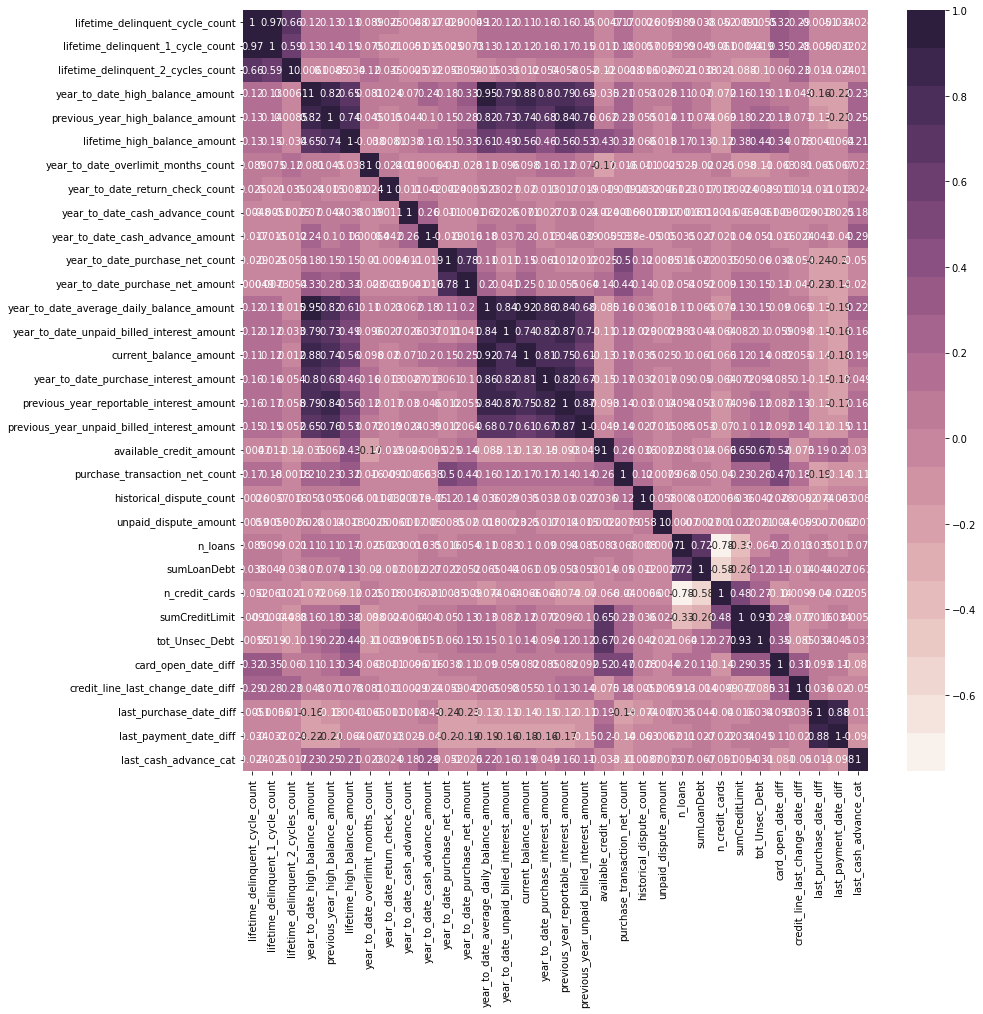

In [304]:
xs = model_data.drop(['credit_line_amount'], axis=1)
plt.figure(figsize=(14,14))
corrp = sns.heatmap(xs.corr(), annot=True, cmap=sns.cubehelix_palette(20, light=0.95, dark=0.15))
corrp.xaxis.tick_top
plt.show()

Since 'n_loans' is highly correlated with 'sumLoanDebt' and 'n_credit_cards' is highly correlated with 'sumCreditLimit', these two variables 'sumLoanDebt' and 'sumCreditLimit' are kept for modeling. 'ucfID' is also removed because it is irrelevant for modeling

In [305]:
model_data = model_data.drop(columns =['n_loans','n_credit_cards','ucfID'])

Replace 'nan' with 0 in 'sumLoanDebt', 'sumCreditLimit' and 'tot_Unsec_Debt'

In [306]:
def recode_nan_cells(dataframe, list_of_columns):
    for column in list_of_columns:
        dataframe[column] = dataframe[column].replace(np.nan, 0, regex=True)
    return dataframe

col_list = ['sumLoanDebt','sumCreditLimit','tot_Unsec_Debt']
data_1 = recode_nan_cells(model_data, col_list)
data_2 = data_1.reset_index(drop=True)

Export the data_2 with the file name model data with missing.csv

In [307]:
data_2.to_csv('model data with missing.csv', index = False, header=True)
modata = pd.read_csv('model data with missing.csv')

Perform data imputation with mean over 4 variables. After comparing with KNN data imputation, we decide to adapt the KNN data imputation method

In [308]:
datam = modata
datam['Bureau_Score'] = datam['Bureau_Score'].fillna(datam['Bureau_Score'].mean())
datam['Bureau_Score_Date_Difference'] = datam['Bureau_Score_Date_Difference'].fillna(\
    datam['Bureau_Score_Date_Difference'].mean())
datam['Credit_Line_Rate'] = datam['Credit_Line_Rate'].fillna(datam['Credit_Line_Rate'].mean())
datam['Credit_Line_Rate_Difference'] = datam['Credit_Line_Rate_Difference'].fillna(\
    datam['Credit_Line_Rate_Difference'].mean())

Perform data imputation with KNN method. Use the suggested n_neighbors = 172 which is the square root of the number of observations. After KNN imputation, we have Data as our model data

In [309]:
imputer = KNNImputer(n_neighbors = 172, weights='uniform', metric='nan_euclidean')
imputer.fit(modata)
Xtrans = imputer.transform(modata) 
Xtrans = pd.DataFrame(Xtrans)
col = modata.columns
Xtrans.columns = col
Data = Xtrans

After KNN imputatiom, plot the correlation heatmap with model_data without target variable 'credit_line_amount'

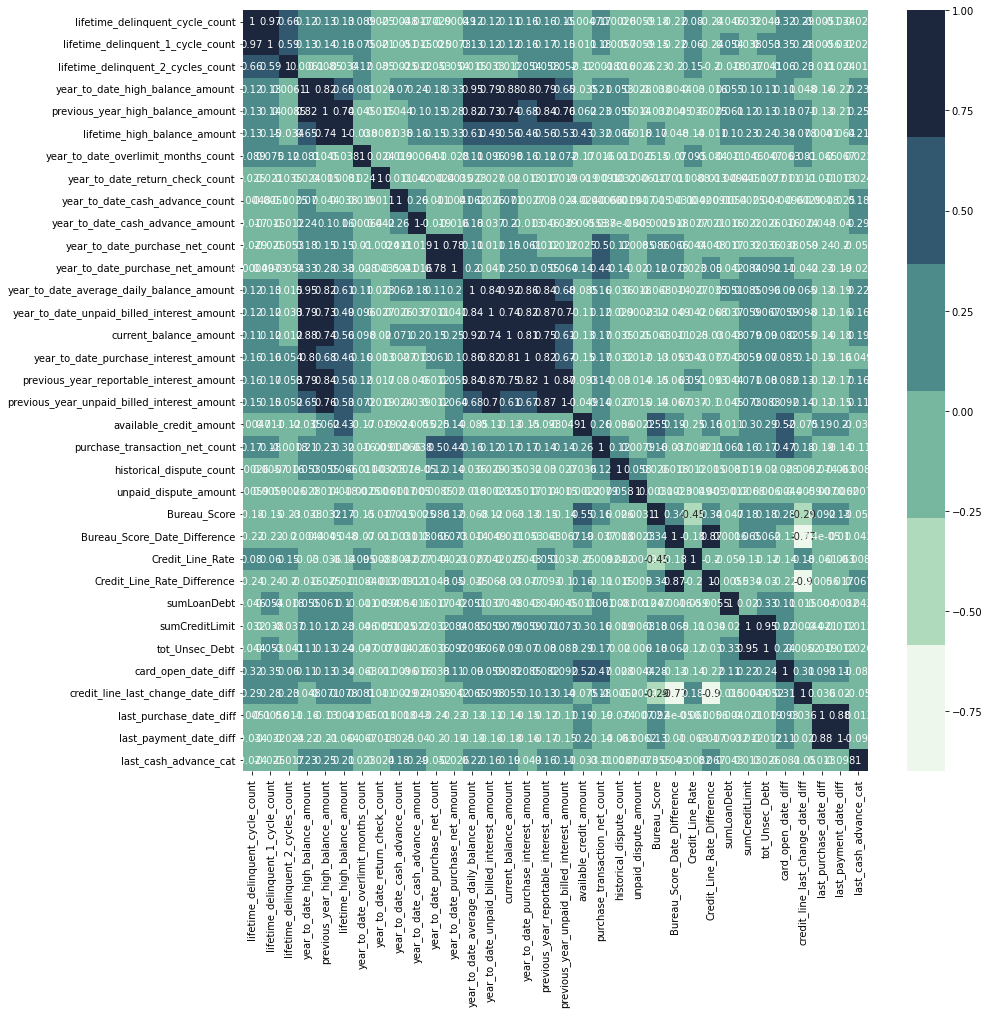

In [310]:
xdf = Data.drop(['credit_line_amount'], axis=1)
plt.figure(figsize=(14,14))
corrp2 = sns.heatmap(xdf.corr(), annot=True, cmap=sns.cubehelix_palette(rot=-.4, light=0.95, dark=0.15))
corrp2.xaxis.tick_top
plt.show()

By the correlation plot, remove the following predictors which have high correlations with certain predictors

In [311]:
NEWdata = Data.drop(columns =['lifetime_delinquent_1_cycle_count','lifetime_high_balance_amount',
                              'lifetime_delinquent_2_cycles_count','previous_year_high_balance_amount',
                              'year_to_date_high_balance_amount','previous_year_reportable_interest_amount',
                              'previous_year_unpaid_billed_interest_amount','year_to_date_purchase_net_count',
                              'year_to_date_purchase_interest_amount','year_to_date_unpaid_billed_interest_amount',
                              'Credit_Line_Rate_Difference','current_balance_amount','tot_Unsec_Debt',
                              'last_purchase_date_diff','Bureau_Score_Date_Difference'])

Identify the predictors as X and target as y. Also adjust the predictor "last_cash_advance_cat" as categorical data (binary levels)

In [43]:
X = NEWdata.drop(['credit_line_amount'], axis=1)
X["last_cash_advance_cat"] = X["last_cash_advance_cat"].astype("category")
y = NEWdata.credit_line_amount

Data partition as 80% training set and 20% test set

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

Perform 8 models to compare results for predictions with MSE, MAE and R^2 as metrics

1. Bagged Tree

In [76]:
bag = BaggingRegressor(n_estimators = 120, random_state=42)
bag.fit(X_train, y_train)
y_bag_train_pred = bag.predict(X_train)
y_bag_test_pred = bag.predict(X_test)
bag_train_mse = mean_squared_error(y_train, y_bag_train_pred)
bag_train_mae = mean_absolute_error(y_train, y_bag_train_pred)
bag_train_r2 = r2_score(y_train, y_bag_train_pred)
bag_test_mse = mean_squared_error(y_test, y_bag_test_pred)
bag_test_mae = mean_absolute_error(y_test, y_bag_test_pred)
bag_test_r2 = r2_score(y_test, y_bag_test_pred)
bag_results = pd.DataFrame(['Bagged Tree',bag_train_mse, bag_train_mae, bag_train_r2,
                            bag_test_mse, bag_test_mae, bag_test_r2]).transpose()
bag_results.columns = ['Method','Training MSE', 'Training MAE','Training R2','Test MSE','Test MAE','Test R2']

2. Random Forest

In [47]:
rf = RandomForestRegressor(max_depth=20, random_state=42)
rf.fit(X_train, y_train)
y_rf_train_pred = rf.predict(X_train)
y_rf_test_pred = rf.predict(X_test)
rf_train_mse = mean_squared_error(y_train, y_rf_train_pred)
rf_train_mae = mean_absolute_error(y_train, y_rf_train_pred)
rf_train_r2 = r2_score(y_train, y_rf_train_pred)
rf_test_mse = mean_squared_error(y_test, y_rf_test_pred)
rf_test_mae = mean_absolute_error(y_test, y_rf_test_pred)
rf_test_r2 = r2_score(y_test, y_rf_test_pred)
rf_results = pd.DataFrame(['Random forest',rf_train_mse, rf_train_mae, rf_train_r2,
                            rf_test_mse, rf_test_mae, rf_test_r2]).transpose()
rf_results.columns = ['Method','Training MSE', 'Training MAE','Training R2','Test MSE','Test MAE','Test R2']

3. Gradient Boosting

In [49]:
gb_params = {'n_estimators': 1000,
          'max_depth': 3,
          'min_samples_split': 5,
          'learning_rate': 0.01,
          'loss': 'ls'}

gb = GradientBoostingRegressor(**gb_params)
gb.fit(X_train, y_train)
y_gb_train_pred = gb.predict(X_train)
y_gb_test_pred = gb.predict(X_test)
gb_train_mse = mean_squared_error(y_train, y_gb_train_pred)
gb_train_mae = mean_absolute_error(y_train, y_gb_train_pred)
gb_train_r2 = r2_score(y_train, y_gb_train_pred)
gb_test_mse = mean_squared_error(y_test, y_gb_test_pred)
gb_test_mae = mean_absolute_error(y_test, y_gb_test_pred)
gb_test_r2 = r2_score(y_test, y_gb_test_pred)
gb_results = pd.DataFrame(['Gradient Boosting',gb_train_mse, gb_train_mae, gb_train_r2,
                            gb_test_mse, gb_test_mae, gb_test_r2]).transpose()
gb_results.columns = ['Method','Training MSE', 'Training MAE','Training R2','Test MSE','Test MAE','Test R2']

4. Linear Regression

In [51]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_lr_train_pred = lr.predict(X_train)
y_lr_test_pred = lr.predict(X_test)
lr_train_mse = mean_squared_error(y_train, y_lr_train_pred)
lr_train_mae = mean_absolute_error(y_train, y_lr_train_pred)
lr_train_r2 = r2_score(y_train, y_lr_train_pred)
lr_test_mse = mean_squared_error(y_test, y_lr_test_pred)
lr_test_mae = mean_absolute_error(y_test, y_lr_test_pred)
lr_test_r2 = r2_score(y_test, y_lr_test_pred)
lr_results = pd.DataFrame(['Linear regression',lr_train_mse, lr_train_mae, lr_train_r2, 
                           lr_test_mse, lr_test_mae, lr_test_r2]).transpose()
lr_results.columns = ['Method','Training MSE', 'Training MAE','Training R2','Test MSE','Test MAE','Test R2']

5. Extra Tree

In [52]:
et = ExtraTreeRegressor(random_state=42)
et.fit(X_train, y_train)
y_et_train_pred = et.predict(X_train)
y_et_test_pred = et.predict(X_test)
et_train_mse = mean_squared_error(y_train, y_et_train_pred)
et_train_mae = mean_absolute_error(y_train, y_et_train_pred)
et_train_r2 = r2_score(y_train, y_et_train_pred)
et_test_mse = mean_squared_error(y_test, y_et_test_pred)
et_test_mae = mean_absolute_error(y_test, y_et_test_pred)
et_test_r2 = r2_score(y_test, y_et_test_pred)
et_results = pd.DataFrame(['Extra Tree', et_train_mse, et_train_mae, et_train_r2, 
                           et_test_mse, et_test_mae, et_test_r2]).transpose()
et_results.columns = ['Method','Training MSE', 'Training MAE','Training R2','Test MSE','Test MAE','Test R2']

6. Decision Tree

In [53]:
dt = DecisionTreeRegressor(random_state=42)
dt.fit(X_train, y_train)
y_dt_train_pred = dt.predict(X_train)
y_dt_test_pred = dt.predict(X_test)
dt_train_mse = mean_squared_error(y_train, y_dt_train_pred)
dt_train_mae = mean_absolute_error(y_train, y_dt_train_pred)
dt_train_r2 = r2_score(y_train, y_dt_train_pred)
dt_test_mse = mean_squared_error(y_test, y_dt_test_pred)
dt_test_mae = mean_absolute_error(y_test, y_dt_test_pred)
dt_test_r2 = r2_score(y_test, y_dt_test_pred)
dt_results = pd.DataFrame(['Decision Tree', dt_train_mse, dt_train_mae, dt_train_r2,
                           dt_test_mse, dt_test_mae, dt_test_r2]).transpose()
dt_results.columns = ['Method','Training MSE', 'Training MAE','Training R2','Test MSE','Test MAE','Test R2']

7. Multilayer Perceptron

In [54]:
mlp = MLPRegressor()
mlp.fit(X_train, y_train)
y_mlp_train_pred = mlp.predict(X_train)
y_mlp_test_pred = mlp.predict(X_test)
mlp_train_mse = mean_squared_error(y_train, y_mlp_train_pred)
mlp_train_mae = mean_absolute_error(y_train, y_mlp_train_pred)
mlp_train_r2 = r2_score(y_train, y_mlp_train_pred)
mlp_test_mse = mean_squared_error(y_test, y_mlp_test_pred)
mlp_test_mae = mean_absolute_error(y_test, y_mlp_test_pred)
mlp_test_r2 = r2_score(y_test, y_mlp_test_pred)
mlp_results = pd.DataFrame(['MLP', mlp_train_mse, mlp_train_mae, mlp_train_r2,
                           mlp_test_mse, mlp_test_mae, mlp_test_r2]).transpose()
mlp_results.columns = ['Method','Training MSE', 'Training MAE','Training R2','Test MSE','Test MAE','Test R2']

8. LASSO

In [55]:
la = Lasso(alpha=1.0)
la.fit(X_train, y_train)
y_la_train_pred = la.predict(X_train)
y_la_test_pred = la.predict(X_test)
la_train_mse = mean_squared_error(y_train, y_la_train_pred)
la_train_mae = mean_absolute_error(y_train, y_la_train_pred)
la_train_r2 = r2_score(y_train, y_la_train_pred)
la_test_mse = mean_squared_error(y_test, y_la_test_pred)
la_test_mae = mean_absolute_error(y_test, y_la_test_pred)
la_test_r2 = r2_score(y_test, y_la_test_pred)
la_results = pd.DataFrame(['Lasso',la_train_mse, la_train_mae, la_train_r2,
                            la_test_mse, la_test_mae, la_test_r2]).transpose()
la_results.columns = ['Method','Training MSE', 'Training MAE','Training R2','Test MSE','Test MAE','Test R2']

Combine the accuracy results from 8 models altogether

In [71]:
result = pd.concat([bag_results, rf_results, gb_results, lr_results, et_results, dt_results, mlp_results, la_results])
result

,Method,Training MSE,Training MAE,Training R2,Test MSE,Test MAE,Test R2
0,Bagged Tree,289718.194919,151.888743,0.997064,828141.283185,394.966431,0.991493
0,Random forest,267363.220943,155.492836,0.99729,825140.012109,394.040831,0.991523
0,Gradient Boosting,776266.126546,459.978596,0.992133,840437.737894,473.890174,0.991366
0,Linear regression,1511432.371039,583.530415,0.984682,1253831.76029,579.315301,0.98712
0,Extra Tree,0.0,0.0,1.0,1811832.795344,559.703735,0.981387
0,Decision Tree,0.0,0.0,1.0,1584861.417016,500.944398,0.983719
0,MLP,807786.751983,453.989492,0.991813,902490.369199,471.109508,0.990729
0,Lasso,1511472.086066,583.416631,0.984682,1254251.451313,579.123364,0.987115


Since we use data partition while finding the models, we also try 10-fold cross validation for modeling to have more general results and decide the final model afterward. Another accuracy table including test MSE, test MAE and test R2 will be shown later

1. Bagged tree with 10-fold cross validation

In [77]:
bag_test_cv = cross_validate(bag, X, y, cv=10, scoring=('r2', 'neg_mean_squared_error', 'neg_mean_absolute_error'))
bag_test_r2_cv = statistics.mean(bag_test_cv['test_r2'])
bag_test_mse_cv = abs(statistics.mean(bag_test_cv['test_neg_mean_squared_error']))
bag_test_mae_cv = abs(statistics.mean(bag_test_cv['test_neg_mean_absolute_error']))
bag_results_cv = pd.DataFrame(['Bagged Tree', bag_test_mse_cv, bag_test_mae_cv, bag_test_r2_cv]).transpose()
bag_results_cv.columns = ['Method','Test MSE','Test MAE','Test R2']

2. Random forest with 10-fold cross validation

In [79]:
rf_test_cv = cross_validate(rf, X, y, cv=10, scoring=('r2', 'neg_mean_squared_error', 'neg_mean_absolute_error'))
rf_test_r2_cv = statistics.mean(rf_test_cv['test_r2'])
rf_test_mse_cv = abs(statistics.mean(rf_test_cv['test_neg_mean_squared_error']))
rf_test_mae_cv = abs(statistics.mean(rf_test_cv['test_neg_mean_absolute_error']))
rf_results_cv = pd.DataFrame(['Random Forest', rf_test_mse_cv, rf_test_mae_cv, rf_test_r2_cv]).transpose()
rf_results_cv.columns = ['Method','Test MSE','Test MAE','Test R2']

3. Gradient boosting with 10-fold cross validation

In [81]:
gb_test_cv = cross_validate(gb, X, y, cv=10, scoring=('r2', 'neg_mean_squared_error', 'neg_mean_absolute_error'))
gb_test_r2_cv = statistics.mean(gb_test_cv['test_r2'])
gb_test_mse_cv = abs(statistics.mean(gb_test_cv['test_neg_mean_squared_error']))
gb_test_mae_cv = abs(statistics.mean(gb_test_cv['test_neg_mean_absolute_error']))
gb_results_cv = pd.DataFrame(['Gradient Boosting', gb_test_mse_cv, gb_test_mae_cv, gb_test_r2_cv]).transpose()
gb_results_cv.columns = ['Method','Test MSE','Test MAE','Test R2']

4. Linear regression with 10-fold cross validation

In [83]:
lr_test_cv = cross_validate(lr, X, y, cv=10, scoring=('r2', 'neg_mean_squared_error', 'neg_mean_absolute_error'))
lr_test_r2_cv = statistics.mean(lr_test_cv['test_r2'])
lr_test_mse_cv = abs(statistics.mean(lr_test_cv['test_neg_mean_squared_error']))
lr_test_mae_cv = abs(statistics.mean(lr_test_cv['test_neg_mean_absolute_error']))
lr_results_cv = pd.DataFrame(['Linear Regression', lr_test_mse_cv, lr_test_mae_cv, lr_test_r2_cv]).transpose()
lr_results_cv.columns = ['Method','Test MSE','Test MAE','Test R2']

5. Extra tree with 10-fold cross validation

In [85]:
et_test_cv = cross_validate(et, X, y, cv=10, scoring=('r2', 'neg_mean_squared_error', 'neg_mean_absolute_error'))
et_test_r2_cv = statistics.mean(et_test_cv['test_r2'])
et_test_mse_cv = abs(statistics.mean(et_test_cv['test_neg_mean_squared_error']))
et_test_mae_cv = abs(statistics.mean(et_test_cv['test_neg_mean_absolute_error']))
et_results_cv = pd.DataFrame(['Extra Tree', et_test_mse_cv, et_test_mae_cv, et_test_r2_cv]).transpose()
et_results_cv.columns = ['Method','Test MSE','Test MAE','Test R2']

6. Decision tree with 10-fold cross validation

In [86]:
dt_test_cv = cross_validate(dt, X, y, cv=10, scoring=('r2', 'neg_mean_squared_error', 'neg_mean_absolute_error'))
dt_test_r2_cv = statistics.mean(dt_test_cv['test_r2'])
dt_test_mse_cv = abs(statistics.mean(dt_test_cv['test_neg_mean_squared_error']))
dt_test_mae_cv = abs(statistics.mean(dt_test_cv['test_neg_mean_absolute_error']))
dt_results_cv = pd.DataFrame(['Decision Tree', dt_test_mse_cv, dt_test_mae_cv, dt_test_r2_cv]).transpose()
dt_results_cv.columns = ['Method','Test MSE','Test MAE','Test R2']

7. Multilayer Perceptron with 10-fold cross validation

In [87]:
mlp_test_cv = cross_validate(mlp, X, y, cv=10, scoring=('r2', 'neg_mean_squared_error', 'neg_mean_absolute_error'))
mlp_test_r2_cv = statistics.mean(mlp_test_cv['test_r2'])
mlp_test_mse_cv = abs(statistics.mean(mlp_test_cv['test_neg_mean_squared_error']))
mlp_test_mae_cv = abs(statistics.mean(mlp_test_cv['test_neg_mean_absolute_error']))
mlp_results_cv = pd.DataFrame(['MLP', mlp_test_mse_cv, mlp_test_mae_cv, mlp_test_r2_cv]).transpose()
mlp_results_cv.columns = ['Method','Test MSE','Test MAE','Test R2']

8. LASSO with 10-fold cross validation

In [88]:
la_test_cv = cross_validate(la, X, y, cv=10, scoring=('r2', 'neg_mean_squared_error', 'neg_mean_absolute_error'))
la_test_r2_cv = statistics.mean(la_test_cv['test_r2'])
la_test_mse_cv = abs(statistics.mean(la_test_cv['test_neg_mean_squared_error']))
la_test_mae_cv = abs(statistics.mean(la_test_cv['test_neg_mean_absolute_error']))
la_results_cv = pd.DataFrame(['Lasso', la_test_mse_cv, la_test_mae_cv, la_test_r2_cv]).transpose()
la_results_cv.columns = ['Method','Test MSE','Test MAE','Test R2']

Combine the accuracy results using cross validation from 8 models altogether

In [89]:
result_cv = pd.concat([bag_results_cv, rf_results_cv, gb_results_cv, lr_results_cv, et_results_cv, dt_results_cv,\
                       mlp_results_cv, la_results_cv])
result_cv

,Method,Test MSE,Test MAE,Test R2
0,Bagged Tree,1591372.039755,403.392867,0.984487
0,Random Forest,1696577.540138,404.609685,0.983513
0,Gradient Boosting,1385306.812596,482.16006,0.986364
0,Linear Regression,1469945.31083,577.839111,0.985031
0,Extra Tree,2543686.678007,597.541271,0.974439
0,Decision Tree,2144059.382892,522.218002,0.978546
0,MLP,1268448.358145,498.436198,0.987331
0,Lasso,1468981.171646,577.515384,0.985041


Considering both accuracy results from data partition and cross validation respectively, we decide to adopt bagged tree as our final model

Since the bagged tree is decided to be final model, we perform feature selection using R. This part will be included in R file. After feature selection, the exported csv files are following

In [92]:
data_train = pd.read_csv('bagged data.csv')

Now, bagged tree is decided to be final model and we perform the prediction. We need to extract the 'credit_bureau_score
' from ucf_PSCU_UCF_2021_Data.csv as the predicted score and we put it in a new csv file called predict_score.csv

In [142]:
datap = pd.read_csv('predict_score.csv')

Find nearest date and corresponding score on score data, comparing with the 'credit_bureau_score_date'. Set the present date as the beginning of fall semester which is 2021/8/31

In [145]:
present = datetime.strptime('2021/8/31', '%Y/%m/%d').date()
score_rowindexp = np.zeros(len(datap))
for i in range(len(datap)):
    ucfid = datap.iloc[i,0]
    rows = score.index[score['ucfID'] == ucfid].tolist() 
    if len(rows) == 0:
        score_rowindexp[i] = -1
    else:
        tem = [0 for n in range(len(rows))]
        for j,c in enumerate(rows):
            diff = present - score.iloc[c,-1]
            tem[j] = diff.days # Convert date to day
        score_rowindexp[i] = rows[tem.index(min(tem))]
        
scorevarp = []
score_rowindexp = list(score_rowindexp)
for i in range(len(score_rowindexp)):
    if score_rowindexp[i] == -1:
        scorevarp.append('nan')        
    else:
        scorevarp.append(score.iloc[int(score_rowindexp[i]),1])

Check the number of missing values

In [195]:
scorevarp.count('nan')

7529

Find nearest date on rate data, comparing with the 'credit_bureau_score_date'

In [148]:
rate_rowindexp = np.zeros(len(datap))
for i in range(len(datap)):
    ucfid = datap.iloc[i,0]
    rows = rate.index[rate['ucfID'] == ucfid].tolist() 
    if len(rows) == 0:
        rate_rowindexp[i] = -1
    else:
        tem = [0 for n in range(len(rows))]
        for j,c in enumerate(rows):
            diff = present - rate.iloc[c,-1]
            tem[j] = diff.days # Convert date to day
        rate_rowindexp[i] = rows[tem.index(min(tem))]
        
ratevarp = []
rate_rowindexp = list(rate_rowindexp)
for i in range(len(rate_rowindexp)):
    if rate_rowindexp[i] == -1:
        ratevarp.append('nan')        
    else:
        ratevarp.append(rate.iloc[int(rate_rowindexp[i]),1])

Check the number of missing values

In [149]:
ratevarp.count('nan')

4850

Obtain these two new variables as pd.DataFrame form

In [196]:
scoreandrate = pd.DataFrame({'Bureau_Score':scorevarp, 'Credit_Line_Rate':ratevarp})

Call the data_train and data_predict (scoreandrate)

In [198]:
data_predict = scoreandrate

Replace 'Bureau_Score' by 'BS' and replace 'Credit_Line_Rate' by 'CLR'

In [201]:
data_predict['BS'] = data_predict['Bureau_Score']
data_predict['CLR'] = data_predict['Credit_Line_Rate']
data_predict = data_predict.drop(columns=['Bureau_Score','Credit_Line_Rate'])

Combine data_train and data_predict, and call it datapre. Also remove the missing value in datapre

In [226]:
datapre = pd.concat([data_train,data_predict], axis = 1)
datapre['BS'] = datapre['BS'].replace('nan', np.nan)
datapre['CLR'] = datapre['CLR'].replace('nan', np.nan)
datapre = datapre.dropna(axis='index', how='any', subset=['BS','CLR'])

Drop these variables 'year_to_date_average_daily_balance_amount','sumCreditLimit','credit_line_amount','BS','CLR' in datapre and call it X_train which is the training set

In [230]:
X_train = datapre.drop(['year_to_date_average_daily_balance_amount','sumCreditLimit',\
                     'credit_line_amount','BS','CLR'], axis=1)

Drop these variables 'year_to_date_average_daily_balance_amount','sumCreditLimit', 'credit_line_amount', 'Bureau_Score' and call it X_predict which is for prediction and call 'credit_line_amount' as y

In [237]:
X_predict = datapre.drop(['year_to_date_average_daily_balance_amount','sumCreditLimit',\
                       'credit_line_amount', 'Bureau_Score'], axis=1)
X_predict = X_predict[['available_credit_amount','BS','CLR']]
X_predict['Bureau_Score'] = X_predict['BS']
X_predict['Credit_Line_Rate'] = X_predict['CLR']
X_predict = X_predict.drop(columns=['BS','CLR'])
y = datapre.credit_line_amount

As we mentioned above, bagged tree is final model. We use X_train to train model and obtain predicted y calculated by X_train. Also the R-square is about 0.9839 which is highly accurate

In [243]:
bag = BaggingRegressor(n_estimators=120, random_state=42)
bag.fit(X_train, y)
y_bag_train_pred = bag.predict(X_train) 
bag_train_r2 = r2_score(y, y_bag_train_pred)
bag_train_r2

0.9839408716457394

Obtained another predicted_y calculated by X_predict

In [250]:
y_pred = bag.predict(X_predict)  

Find the difference between predicted_y and actual y, so we can build strategy

In [251]:
diffp = y_pred - y
diffp = list(diffp)
diffp.index(min(diffp))
diffp.pop(2787)

-65525.0

Plot the difference between predicted_y and actual y

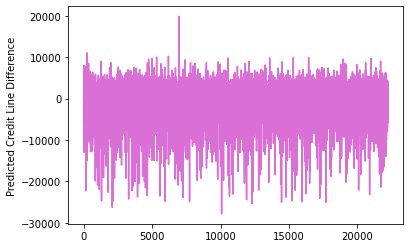

In [256]:
plt.plot(diffp, color = 'orchid')
plt.ylabel('Predicted Credit Line Difference')
plt.show()

Plot the difference between 'BS' and 'Bureau_Score'

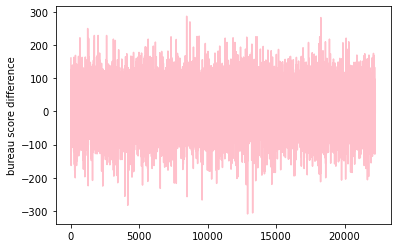

In [257]:
temp = datapre['BS'] - datapre['Bureau_Score']
temp = list(temp)
plt.plot(temp, color = 'pink')
plt.ylabel('bureau score difference')
plt.show()

In [259]:
countp = 0
for i in range(len(diffp)):
    if diffp[i]<0:
        countp += 1

In [261]:
countp

5717

Building strategies

Combine X_predict, y_pred and actual y

In [314]:
full = pd.concat([X_predict, y], axis=1)
full['new_credit_line'] = y_pred

Find the difference between 'new_credit_line' that we predicted and 'credit_line_amount' and we name it 'credit_change'

In [315]:
full['credit_change'] = full['new_credit_line']-full['credit_line_amount']
full = full.drop(columns=['available_credit_amount'])

For the difference 'credit_change' that is negative, the values become zero

In [316]:
full[full<0] = 0

Subset full data into groups based on the three final predictors we decide to use. They are 'credit_line_amount', 'Credit_Line_Rate' and 'Bureau_Score'

Credit line changed

In [317]:
group1 = full.loc[(full['credit_line_amount']<=10000) & (full['Credit_Line_Rate']<=10000)\
                  & (full['Bureau_Score']<=669)]
group2 = full.loc[(~full['credit_line_amount'].between(10001, 20000)) & (full['Credit_Line_Rate']<=10000)\
                  & (full['Bureau_Score']<=669)]
group3 = full.loc[(full['credit_line_amount']>=20001) & (full['Credit_Line_Rate']<=10000)\
                  & (full['Bureau_Score']<=669)]

Credit line and credit line rate changed

In [318]:
group4 = full.loc[(full['credit_line_amount']<=10000) & (~full['Credit_Line_Rate'].between(10001, 16000))\
                  & (full['Bureau_Score']<=669)]
group5 = full.loc[(full['credit_line_amount']<=10000) & (full['Credit_Line_Rate']>=16001)\
                  & (full['Bureau_Score']<=669)]
    
group6 = full.loc[(~full['credit_line_amount'].between(10001, 20000)) & (~full['Credit_Line_Rate'].between(10001, 16000))\
                  & (full['Bureau_Score']<=669)]
group7 = full.loc[(~full['credit_line_amount'].between(10001, 20000)) & (full['Credit_Line_Rate']>=16001)\
                  & (full['Bureau_Score']<=669)]
    
group8 = full.loc[(full['credit_line_amount']>=20001) & (~full['Credit_Line_Rate'].between(10001, 16000))\
                  & (full['Bureau_Score']<=669)]
group9 = full.loc[(full['credit_line_amount']>=20001) & (full['Credit_Line_Rate']>=16001)\
                  & (full['Bureau_Score']<=669)]

Credit line and bureau score changed

In [319]:
group10 = full.loc[(full['credit_line_amount']<=10000) & (full['Credit_Line_Rate']<=10000)\
                  & (~full['Bureau_Score'].between(670,799))]
group11 = full.loc[(full['credit_line_amount']<=10000) & (full['Credit_Line_Rate']<=10000)\
                  & (full['Bureau_Score']>=800)]
   
group12 = full.loc[(~full['credit_line_amount'].between(10001, 20000)) & (full['Credit_Line_Rate']<=10000)\
                  & (~full['Bureau_Score'].between(670,799))]
group13 = full.loc[(~full['credit_line_amount'].between(10001, 20000)) & (full['Credit_Line_Rate']<=10000)\
                  & (full['Bureau_Score']>=800)]

group14 = full.loc[(full['credit_line_amount']>=20001) & (full['Credit_Line_Rate']<=10000)\
                  & (~full['Bureau_Score'].between(670,799))]
group15 = full.loc[(full['credit_line_amount']>=20001) & (full['Credit_Line_Rate']<=10000)\
                  & (full['Bureau_Score']>=800)]

Credit line and bureau score changed

In [321]:
group16 = full.loc[(full['credit_line_amount']<=10000) & (~full['Credit_Line_Rate'].between(10001, 16000))\
                  & (~full['Bureau_Score'].between(670,799))]
group17 = full.loc[(full['credit_line_amount']<=10000) & (~full['Credit_Line_Rate'].between(10001, 16000))\
                  & (full['Bureau_Score']>=800)]
   
group18 = full.loc[(~full['credit_line_amount'].between(10001, 20000)) & (~full['Credit_Line_Rate'].between(10001, 16000))\
                  & (~full['Bureau_Score'].between(670,799))]
group19 = full.loc[(~full['credit_line_amount'].between(10001, 20000)) & (~full['Credit_Line_Rate'].between(10001, 16000))\
                  & (full['Bureau_Score']>=800)]

group20 = full.loc[(full['credit_line_amount']>=20001) & (~full['Credit_Line_Rate'].between(10001, 16000))\
                  & (~full['Bureau_Score'].between(670,799))]
group21 = full.loc[(full['credit_line_amount']>=20001) & (~full['Credit_Line_Rate'].between(10001, 16000))\
                  & (full['Bureau_Score']>=800)]

Credit line and bureau score change    

In [322]:
group22 = full.loc[(full['credit_line_amount']<=10000) & (full['Credit_Line_Rate']>=16001)\
                  & (~full['Bureau_Score'].between(670,799))]
group23 = full.loc[(full['credit_line_amount']<=10000) & (full['Credit_Line_Rate']>=16001)\
                  & (full['Bureau_Score']>=800)]
   
group24 = full.loc[(~full['credit_line_amount'].between(10001, 20000)) & (full['Credit_Line_Rate']>=16001)\
                  & (~full['Bureau_Score'].between(670,799))]
group25 = full.loc[(~full['credit_line_amount'].between(10001, 20000)) & (full['Credit_Line_Rate']>=16001)\
                  & (full['Bureau_Score']>=800)]

group26 = full.loc[(full['credit_line_amount']>=20001) & (full['Credit_Line_Rate']>=16001)\
                  & (~full['Bureau_Score'].between(670,799))]
group27 = full.loc[(full['credit_line_amount']>=20001) & (full['Credit_Line_Rate']>=16001)\
                  & (full['Bureau_Score']>=800)]

Calculate mean increased credit line in each group

In [324]:
mean_1 = mean(group1['credit_change'])
mean_2 = mean(group2['credit_change'])
mean_3 = mean(group3['credit_change'])
mean_4 = mean(group4['credit_change'])
mean_5 = mean(group5['credit_change'])
mean_6 = mean(group6['credit_change'])
mean_7 = mean(group7['credit_change'])
mean_8 = mean(group8['credit_change'])
mean_9 = mean(group9['credit_change'])
mean_10 = mean(group10['credit_change'])
mean_11 = mean(group11['credit_change'])
mean_12 = mean(group12['credit_change'])
mean_13 = mean(group13['credit_change'])
mean_14 = mean(group14['credit_change'])
mean_15 = mean(group15['credit_change'])
mean_16 = mean(group16['credit_change'])
mean_17 = mean(group17['credit_change'])
mean_18 = mean(group18['credit_change'])
mean_19 = mean(group19['credit_change'])
mean_20 = mean(group20['credit_change'])
mean_21 = mean(group21['credit_change'])
mean_22 = mean(group22['credit_change'])
mean_23 = mean(group23['credit_change'])
mean_24 = mean(group24['credit_change'])
mean_25 = mean(group25['credit_change'])
mean_26 = mean(group26['credit_change'])
mean_27 = mean(group27['credit_change'])